---
# Notebook para train-test split
---

# Imports

In [1]:
import pandas as pd
import os
from pathlib import Path
import warnings
import matplotlib.pyplot as plt

# Configs Pandas
pd.options.display.max_columns = None
pd.options.display.max_colwidth = 200

warnings.filterwarnings("ignore")

In [2]:
project_root = Path().resolve().parents[0]

In [3]:
df = pd.read_parquet(os.path.join(project_root, "data", "interim", "dados.parquet"))

# Out of time split -> Train-Test

Dessa forma, com out-of-time, garantimos maior proxy de performance com a que teremos em produção.

In [4]:
df['fecha'].min(), df['fecha'].max(), (df['fecha'].max() - df['fecha'].min())

(Timestamp('2020-03-08 00:02:15'),
 Timestamp('2020-04-21 23:59:56'),
 Timedelta('44 days 23:57:41'))

In [5]:
df['week_of_the_year'].value_counts().sort_index()

week_of_the_year
10     2838
11    24523
12    25199
13    20069
14    17434
15    24443
16    25332
17    10162
Name: count, dtype: int64

In [6]:
df[df['fraude']==1]['week_of_the_year'].value_counts().sort_index()

week_of_the_year
10     124
11    1184
12    1149
13    1142
14    1008
15    1322
16    1087
17     484
Name: count, dtype: int64

In [7]:
volume = df['week_of_the_year'].value_counts().sort_index()

In [8]:
sum(volume[-2:]) / sum(volume)

0.23662666666666668

Vamos treinar nosso modelo com aproximadamente 76% e testar em 24%.\
Dentro do conjunto de treino, faremos um split out of sample para gerar um conjunto de validação e assim poder treinar e tunar o modelo.

In [9]:
df.loc[(~df['week_of_the_year'].isin([16, 17])), 'set'] = 'treino'
df.loc[(df['week_of_the_year'].isin([16, 17])), 'set'] = 'teste'

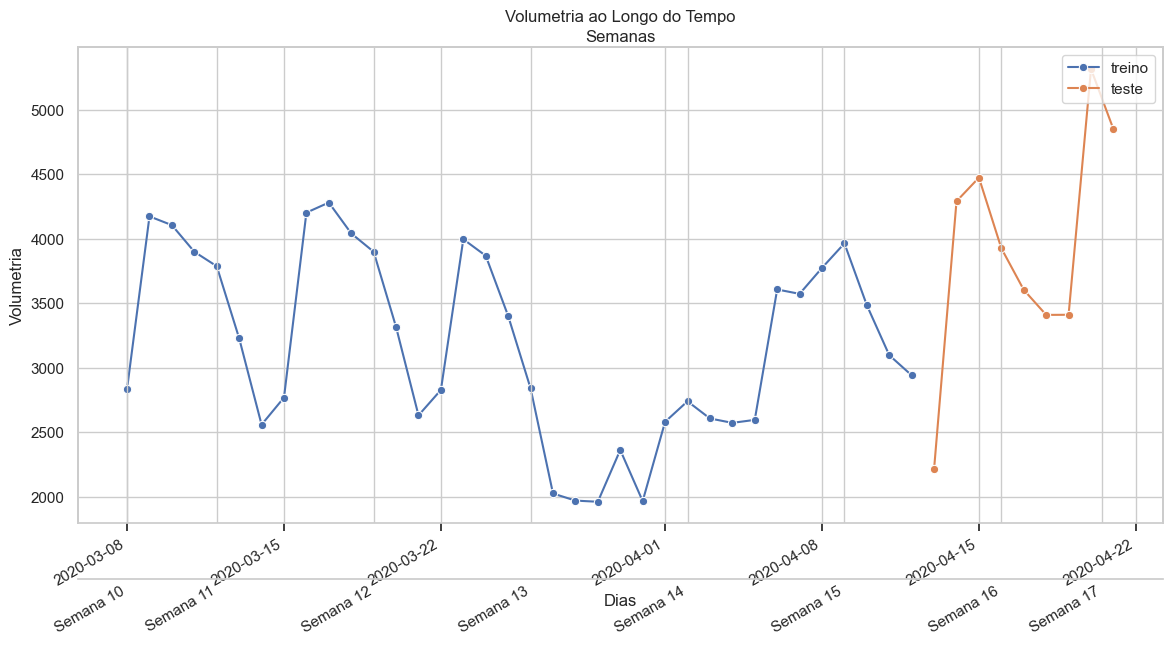

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import pandas as pd

# Supondo que 'df' já esteja carregado e tenha as colunas 'date', 'week_of_the_year', 'set' e 'fraude'

# Agregar dados por data e conjunto
df_agg = df.groupby(['date', 'week_of_the_year', 'set']).agg(
    volumetria=('fraude', 'size')
).reset_index()

# Converter 'date' para datetime, se necessário
df_agg['date'] = pd.to_datetime(df_agg['date'])

# Configurar o estilo do seaborn
sns.set(style="whitegrid")

# Criar a figura e o eixo principal para os dias
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plotar a volumetria com os dias no eixo x
sns.lineplot(data=df_agg, x='date', y='volumetria', hue='set', ax=ax1, marker='o')

# Criar um segundo eixo x para exibir as semanas
ax2 = ax1.twiny()

# Reposicionar o ax2 para ficar abaixo do gráfico
ax2.xaxis.set_ticks_position('bottom')
ax2.spines["bottom"].set_position(("outward", 40))
ax2.set_frame_on(True)
ax2.patch.set_visible(False)
ax2.tick_params(axis='x', which='both', length=0)

# Calcular a posição central (média) de cada semana para posicionar os rótulos
week_positions = []
week_labels = []
for week in sorted(df_agg['week_of_the_year'].unique()):
    week_data = df_agg[df_agg['week_of_the_year'] == week]
    pos = mdates.date2num(week_data['date'].mean())  # converter para número de data
    week_positions.append(pos)
    week_labels.append(f'Semana {week}')

# Definir os ticks do segundo eixo (ax2) com os rótulos das semanas
ax2.set_xticks(week_positions)
ax2.set_xticklabels(week_labels)

# Sincronizar os limites do ax2 com o ax1
ax2.set_xlim(ax1.get_xlim())

# Configurar os rótulos dos eixos
ax1.set_xlabel('Dias')
ax1.set_ylabel('Volumetria')
ax2.set_xlabel('Semanas')

# Adicionar título
plt.title('Volumetria ao Longo do Tempo')

# Ajustar a formatação dos rótulos de data
fig.autofmt_xdate()

# Exibir a legenda e o gráfico
ax1.legend(loc='upper right')
plt.show()